# Analyze the 1000 Genome Mosaic Outputs
Idea: Analyse a large number of samples together, and prepare summary plots.

This codes assumes that the Simulation as well as the HMM Calling has been done, and that the files have been saved according to the guidelines. This code here loads these files, post-process them and provides summary level statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp

if socket.gethostname() == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket.gethostname() == "midway2-0401.rcc.local":
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

Midway jnovmbre partition detected.
/project/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Pre-Process

## First some Functions to Load and Pre-process the data

In [2]:
#############################################
### Functions for Loading

def provide_iid_folders(folder, ch=3, nr_iid = 20, blen_cm = 1, output_prefix = "", error=0):
    """Return a list of folders into which replicate simulations are saved into
    folder: Full folder of the analysis
    ch: Which Chromosome was analyzed
    nr_iid: How many replicate Individual were produced
    bl_cm: The length of the analyzed block class in cM
    output_prefix: Prefix before the File
    error: Whether error was simulated. 0 means no error"""
    
    if error == 0:  # Default
        path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/output/"  # The first part of the Path
    elif error > 0:  # If errors were simulated
        e_print = str(round(error, 4)).split(".")[1] # Extract four digits after decimal 
        path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/error/" + e_print + "/output/"  # The first part of the Path
        
    path_2 = "/chr" + str(ch) + "/" + output_prefix # The last part of the Path (within the folder)
    iid_list = ["iid" + str(i) for i in range(nr_iid)]  # The middle parts of the path
    
    full_paths = [(folder + path_1 + str(i) + path_2)  for i in iid_list]
    return full_paths

def load_observed(path, file="roh.csv"):
    """ Load simulated Dataframe from path"""
    df = pd.read_csv(path + file, sep=",")  # Load the Meta File
    return df

def load_simulated(path, file="roh_gt.csv"):
    """ Load Ground Truth Dataframe from path"""
    df = pd.read_csv(path + file, sep="\t")  # Load the Meta File
    return df

#############################################
### Functions for Analysis

def find_overlap(l, min_l, max_l):
    """ Find overlap of Interval l with intervals starting at min_l and ending at max_l
    Return max overlap as well as Block length (or 0, 0 if no overlap)
    l: Interval [Length 2 list]
    min_l: Minimum Interval Lengths
    max_l: Maximum Interval Lengths"""
    assert(len(l)==2)
    assert(len(min_l) == len(max_l))
    
    if len(min_l)==0: # If no interval given return 0 Overlap 0 total Length
        return 0, 0
    
    min_both = np.maximum(l[0], min_l)
    max_both = np.minimum(l[1], max_l)  
    overlap = max_both - min_both   # Calculate the Overlap
    
    i = np.argmax(overlap)
    max_overlap = overlap[i]
    
    if max_overlap < 0:
        return 0., 0.   # Return 0 Overlap and 0 total length
    
    else:
        orginal_length = max_l[i] - min_l[i]
        return max_overlap, orginal_length
    
    
def check_obs_vrs_sim(df_o, df_s):
    """Analyze observed . 
    Input: 2 Dataframes
    Output: 1 Dataframe
    Return: One dateframe with intersecting [Overlap, CalledLength, Originallength, Position]"""
    begin_obs = df_o["StartM"].values * 100  # Factor 100: To do everything in centiMorgan
    end_obs = df_o["EndM"].values * 100

    overlaps = np.zeros(len(df_s))
    lengths = np.zeros(len(df_s))

    for i, row in df_s.iterrows():
        roh = [row["ROH_Begin"] * 100, row["ROH_End"] * 100]
        ovlp, lgth = find_overlap(roh, begin_obs, end_obs)  # Find the Overlap

        overlaps[i] = ovlp
        lengths[i] = lgth
        
    org_lengths = (df_s["ROH_End"] - df_s["ROH_Begin"]) * 100 ### The original Lengths
    ovlp_frac = overlaps / org_lengths ### Fraction of Block called

    df_call = pd.DataFrame({"Overlap": overlaps, "CalledLength":lengths, "OriginalLength": org_lengths,
                            "OverlapFrac": ovlp_frac, "Position": df_s["ROH_Begin"].values * 100, "iid":df_s["iid"]})

    ###  Create df with Original Length, Found Length, Position, Overlap (Fraction)  
    return df_call

def collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 20, blen_cm = 3, output_prefix="",
                     error = 0, output = False):
    """Create and return the Dataframe with the Power.
    Check every simulated block for overlap.
    error: Whether Error was simulated (needs special path)"""
    

    folders = provide_iid_folders(folder = mosaic_folder, ch=ch, nr_iid = nr_iid, 
                                blen_cm = blen_cm, output_prefix=output_prefix, error=error)   # Load all the folders
        
    df_calls = []
    
    n_call, n_sim = 0, 0  # Number of total called blocks and simulated blocks
    for f in folders:   
        df_o = load_observed(f)   # Loading should throw error if not existend
        df_s = load_simulated(f)
        
        n_call += len(df_o)
        n_sim += len(df_s)

        df_call = check_obs_vrs_sim(df_o, df_s)
        df_calls.append(df_call)
    
    df_calls = pd.concat(df_calls)   # Concatenate all the Results
    
    if output==True:
        print(f"Total Nr Simulated: {n_sim}")
        print(f"Total Nr Called of Simulated: {len(df_calls)}")
        print(f"Total Nr Called: {n_call}")
    
    return df_calls

def collect_fp_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 20, 
                  blen_cm = 3, output_prefix = "", error=0):
    """Collect and return the Dataframe with the false positive Calls"""
    
    folders = provide_iid_folders(folder = mosaic_folder, ch=ch, nr_iid = nr_iid, 
                                  blen_cm = blen_cm, output_prefix=output_prefix, error=error)   # Load all the folders
    
    observed_dfs = [load_observed(f) for f in folders]
    df_observed = pd.concat(observed_dfs)
    return df_observed


#############################################
### Post-Processing the Call Dataframe

def statistics_power_df(df, min_frac=0.8):
    """Report some statistics on the Power Dataframe.
    min_len: Minimum Overlap Length of Block to be counted as a call"""
    l = len(set(df["iid"]))
    no_calls = df["Overlap"]<0.01
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    mean_called = np.mean(df_c["CalledLength"])
    good_call_nr = np.sum(df["OverlapFrac"] > min_frac)
    
    print(f"{l} unique Individuals")
    print(f"{len(df)} total blocks tested")
    print(f"{np.sum(no_calls)} Blocks not called")
    print(f"{good_call_nr} Blocks called > {min_frac*100} %")
    print(f"{mean_called:.4f} average Block Length cM (called)")
        
def calc_power(df, ovlp_frac=0.8):
    """Calculate and return the Power from the Calling Dataframe"""
    
    no_calls = np.sum(df["OverlapFrac"] < ovlp_frac)
    power = 1  - (no_calls / len(df))
    return power

def give_SE(df):
    """Calculate and return Standard Deviation (and maybe quartiles) [in cM]"""
    s = np.std(df["CalledLength"].values)
    return s
    
def give_bias(df, true_lgth):
    """Calculate and return the bias of estimates.
    true_length: Length of simulated blocks [in cM]"""
    b = np.mean(df["CalledLength"].values) - true_lgth
    return b

def return_calls_only(df, ovlp=0.01):
    """Return Dataframe of only called Blocks"""
    no_calls = df["Overlap"]<ovlp
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    return(df_c)

def false_power_statistics(df):
    '''Report some statistics on the false Power Dataframe'''
    bl_lens = df["lengthM"].values
    
    
    print(f"Found {len(bl_lens)} FP blocks")
    if len (bl_lens)>0:
        print(f"Average Block length: {np.mean(bl_lens):.4f} cM")
        print(f"Maximum Block length: {np.max(bl_lens):.4f} cM")

### Statistics of single Run

In [13]:
df_calls = collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 4, 
                            output_prefix="ROHout100/", output=True)
statistics_power_df(df_calls)
calc_power(df_calls)

Total Nr Simulated: 500
Total Nr Called of Simulated: 500
Total Nr Called: 575
100 unique Individuals
500 total blocks tested
0 Blocks not called
489 Blocks called > 80.0 %
4.0573 average Block Length cM (called)


0.978

In [18]:
df_calls = collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 2, 
                            output_prefix="", output=True, error=0.001)
statistics_power_df(df_calls)
calc_power(df_calls)

Total Nr Simulated: 500
Total Nr Called of Simulated: 500
Total Nr Called: 557
100 unique Individuals
500 total blocks tested
3 Blocks not called
464 Blocks called > 80.0 %
2.0361 average Block Length cM (called)


0.928

In [24]:
bl_lens = [2, 4, 6, 8, 10]   # The Length of the Blocks

### Extract Colors from Viridis
cmap = cm.get_cmap("viridis_r")
colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]

### Extract the Pandas Dataframes for called blocks
df_call_vec = [collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = l, output_prefix="ROHin10/") 
            for l in bl_lens]

powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting


###########################
ses = [give_SE(df) for df in df_call_vec1]
bias = [give_bias(df_call_vec1[i], bl_lens[i]) for i in range(len(bl_lens))]

print("Standard Errors:")
print(ses)

print("Biases:")
print(bias)

Standard Errors:
[0.42333273924268167, 0.4781977540482479, 0.3757196592178983, 0.47278934045834486, 0.44050553775379375]
Biases:
[0.19401742399999877, 0.18881508799999924, 0.16879123799999984, 0.21679731800000113, 0.15682484400000085]


# Figures

## Power Plot

In [3]:
def load_power_dfs(mosaic_folder, bl_lens, output_prefix="", n=100, error=0):
    """Load the Power dfs for vector of Block Lengths bl_lens
    n: How many Individuals to load"""
    ### Extract Colors from Viridis
    cmap = cm.get_cmap("viridis_r")

    ### Extract the Pandas Dataframes for called blocks
    df_call_vec = [collect_power_df(mosaic_folder = mosaic_folder, ch=3, nr_iid = n, 
                                    blen_cm = l, output_prefix=output_prefix, error=error) for l in bl_lens]
    powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
    df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting

    return df_call_vec, df_call_vec1, powers

def plot_power(fs = 12, fs_l=12, xlim=(0,12.5), figsize=(10,6), bl_lens=[2, 4, 6, 8, 10], n=100, error=0,
               mosaic_folder = "", output_prefix = "", save=True, title=""):
    """Plot power and power curves"""
    ylim_pow =[0.5, 1.05]
    
    df_call_vec, df_call_vec1, powers = load_power_dfs(mosaic_folder, output_prefix=output_prefix, bl_lens = bl_lens, n=n, error=error)
    
    bins = np.linspace(0, 15, 75)  # Bins of 0.1 cM
    cmap = cm.get_cmap("viridis_r")
    colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]
    
    ####### Do the actual Plot
    plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
    gs.update(hspace=0.04) # set the spacing between axes. 

    ax = plt.subplot(gs[1]) # The lower subplot
    ax1 = plt.subplot(gs[0]) # The upper subplot

    # Plot All Histograms
    for i in range(len(bl_lens)):
        l = bl_lens[i]
        ax.hist(df_call_vec1[i]["CalledLength"], bins = bins, color = colors[i], alpha=0.9, label= str(l) + " cM", ec="silver")
        ax.axvline(l, color = "gray", linewidth=2)

    ax.set_xlim(xlim)
    ax.set_xlabel("Inferred block Length [cM]", fontsize = fs)
    ax.set_ylabel("Inferred ROH length", fontsize = fs)
    ax.legend(loc = "upper right", fontsize = fs_l, title="Simulated ROH")

    ax1.set_ylabel("Called at \n80% overlap", fontsize = fs)
    ax1.set_xticks([])
    ax1.scatter(bl_lens, powers, c=colors, s=100,zorder=1)
    ax1.plot(bl_lens, powers, "gray", zorder=0)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim_pow)

    plt.title(title, fontsize=fs)
    
    if save == True:
        plt.savefig("../../figures/Power/tsi20.png")
    plt.show()

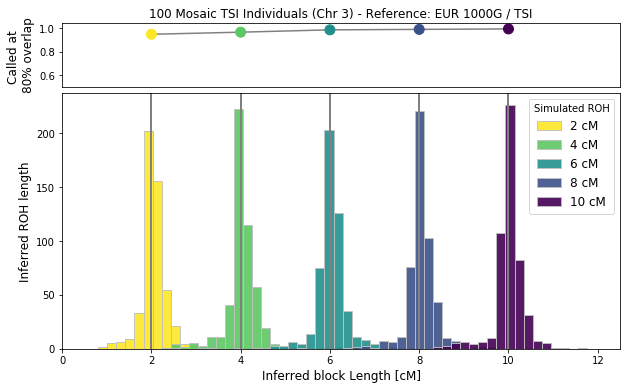

In [25]:
title = "100 Mosaic TSI Individuals (Chr 3) - Reference: EUR 1000G / TSI"
plot_power(bl_lens=[2, 4, 6, 8, 10], mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", output_prefix = "ROHin100/", 
           save=False, title=title, n=100)

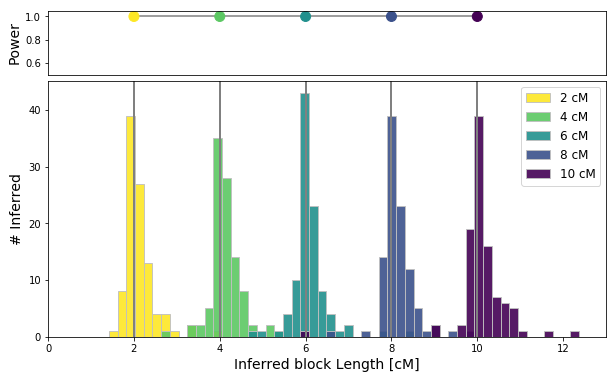

In [15]:
plot_power(bl_lens=[2, 4, 6, 8, 10], mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", 
           output_prefix = "", save=False)

## False Positive Plot

In [4]:
def plot_fp_distribution(fs = 14, fs_l = 12, bins = np.linspace(1, 3, 26), xlim = (0, 13), figsize = (10, 4),
                        title = "100 Mosaic Tuscany Samples - Reference: Rest EUR 1000G", 
                         mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix="", error=0):
    """ Plot the Distribution of false positive ROH calls"""
    
    df_call_fp = collect_fp_df(mosaic_folder = mosaic_folder, ch = ch, nr_iid = nr_iid, blen_cm = blen_cm, 
                               output_prefix = output_prefix, error=error)
    false_power_statistics(df_call_fp)  # Do give some written statistics
    
    ### The Actual Plot
    plt.figure(figsize=figsize)

    ax = plt.gca()
    ax.hist(df_call_fp["lengthM"] * 100, bins = bins, color = "green", alpha=0.9, ec="silver")

    plt.title(title, fontsize=fs)
    ax.set_xlabel("Inferred block Length [cm]", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    plt.show()

Found 343 FP blocks
Average Block length: 0.0129 cM
Maximum Block length: 0.0366 cM


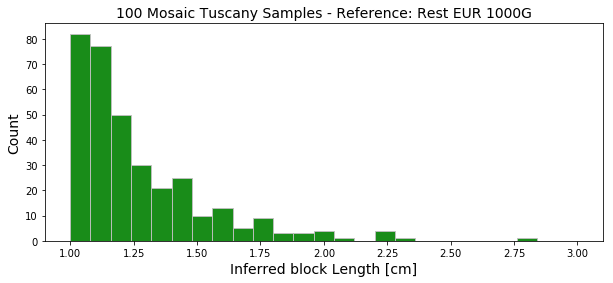

In [33]:
plot_fp_distribution(ch=3, nr_iid = 100, blen_cm = 0, output_prefix="ROH385/", mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/")

Found 175 FP blocks
Average Block length: 0.0124 cM
Maximum Block length: 0.0352 cM


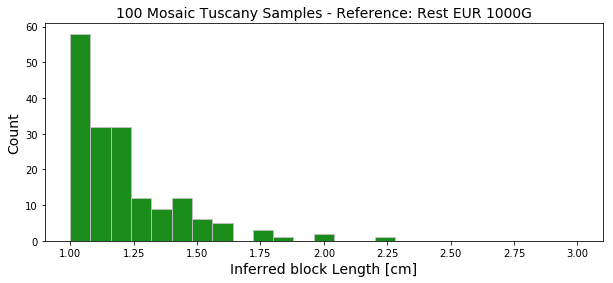

In [30]:
plot_fp_distribution(ch=3, nr_iid = 100, blen_cm = 0, output_prefix="", mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/")

## Output Full Set of Analysis per Run
Requires all Blocks lengths run for all individuals
Rerun the Cell below

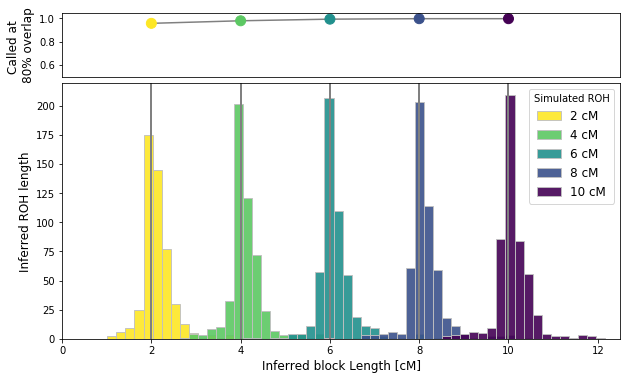

Found 190 FP blocks
Average Block length: 0.0124 cM
Maximum Block length: 0.0347 cM


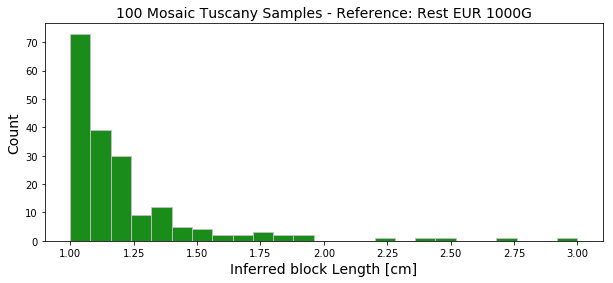

Total Nr Simulated: 500
Total Nr Called of Simulated: 500
Total Nr Called: 642
100 unique Individuals
500 total blocks tested
0 Blocks not called
490 Blocks called > 80.0 %
4.1056 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.3845
Bias: 0.1056


In [6]:
output_prefix = "e01rohin300/" #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
n=100

plot_power(bl_lens=bl_lens, mosaic_folder = mosaic_folder, output_prefix = output_prefix, save=False, title="")
plot_fp_distribution(ch=ch, nr_iid = n, blen_cm = 0, output_prefix=output_prefix, mosaic_folder = mosaic_folder)

df_calls = collect_power_df(mosaic_folder = mosaic_folder, ch=ch, nr_iid = n, blen_cm = bl_focus, 
                            output_prefix=output_prefix, output=True)
statistics_power_df(df_calls)

### Plot Power and SE

df1 = return_calls_only(df_calls)

ses = give_SE(df1)
bias = give_bias(df1, bl_focus)

print(f"Statistics for BL Lengths: {bl_focus}")
print(f"Standard Error: {ses:.4f}")
print(f"Bias: {bias:.4f}")

# Show the Results for Data with error
Show single results with error:

Results for error: 0.0010 with specs for 4 cM


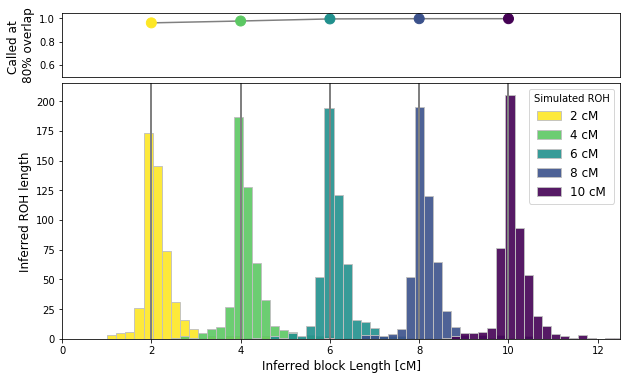

Found 199 FP blocks
Average Block length: 0.0120 cM
Maximum Block length: 0.0347 cM


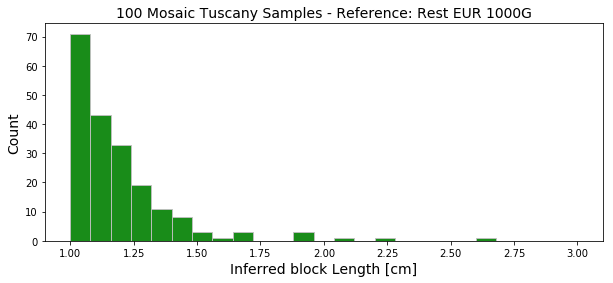

Total Nr Simulated: 500
Total Nr Called of Simulated: 500
Total Nr Called: 641
100 unique Individuals
500 total blocks tested
0 Blocks not called
489 Blocks called > 80.0 %
4.1344 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.4205
Bias: 0.1344


In [56]:
error_vec = np.logspace(-3,-1, 8)
error = error_vec[0]

output_prefix = "e01/" #"ROHin50/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
n=100

print(f"Results for error: {error:.4f} with specs for {bl_focus} cM")
plot_power(bl_lens=bl_lens, mosaic_folder = mosaic_folder, output_prefix = output_prefix, save=False, title="", error= error)
plot_fp_distribution(ch=ch, nr_iid = n, blen_cm = 0, output_prefix=output_prefix, mosaic_folder = mosaic_folder, error = error)

df_calls = collect_power_df(mosaic_folder = mosaic_folder, ch=ch, nr_iid = n, blen_cm = bl_focus, 
                            output_prefix=output_prefix, output=True, error=error)
statistics_power_df(df_calls)

### Plot Power and SE

df1 = return_calls_only(df_calls)

ses = give_SE(df1)
bias = give_bias(df1, bl_focus)

print(f"Statistics for BL Lengths: {bl_focus}")
print(f"Standard Error: {ses:.4f}")
print(f"Bias: {bias:.4f}")

## Plot FP as well as Power at 80 % (4 cM) as function of error

In [18]:
def load_fp_powers(mosaic_folder, error_vec, bl_lens, output_prefix, ch, n=100, min_frac=0.8):
    """Load False Positive Rates, as well as Power Curves
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=len(error_vec), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(error_vec)), dtype="float") # Empty Array for Power
    
    for i, error in enumerate(error_vec):
        print(f"Loading data for Error: {error:.4f}")

        df_call_fp = collect_fp_df(mosaic_folder = mosaic_folder, ch = ch, nr_iid = n, blen_cm = 0, 
                                   output_prefix = output_prefix, error=error)
        fps[i] = len(df_call_fp)
        
        for j, l in enumerate(bl_lens):    
            df_calls = collect_power_df(mosaic_folder = mosaic_folder, ch=ch, nr_iid = n, blen_cm = l, 
                                output_prefix=output_prefix, output=False, error=error)
            good_call_nr = np.sum(df_calls["OverlapFrac"] > min_frac)
            powers[j, i] = good_call_nr/len(df_calls) # Normalize with total number of blocks (simulated)

    print("Successfully loaded complete data!")
    return fps, powers

In [49]:
def plot_fp_power_errors(error_vec, bl_lens, fps, power, title="", savepath=""):
    """Plot False Positive rates as well as power against different error rates
    error_vec: Vector of Errors
    fps: List of false positive Call Numbers
    power: List of power fractions"""
    fs = 14
    figsize = (6,6)
    
    ### Set the Colors
    cmap = cm.get_cmap("viridis_r")
    colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]
    

    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    gs.update(hspace=0.06) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The lower subplot
    ax1 = plt.subplot(gs[1]) # The upper subplot
    
    for i in range(len(bl_lens)):
        ax.plot(error_vec, power[i,:], "o-", color = colors[i], label = f"{bl_lens[i]} cM")
    ax.set_xticks([])
    ax.set_ylabel("Fraction called \nwith 80% overlap", fontsize=fs)
    ax.set_xscale("log")
    ax.legend(loc = "lower left", title="Block Length", fontsize=fs*0.8)

    ax1.plot(error_vec, fps, "go-")
    ax1.errorbar(error_vec, fps, yerr=np.sqrt(fps))
    ax1.set_ylabel("False Positives \nper 100 Chr3", fontsize=fs)
    ax1.set_xscale("log")
    ax1.set_xlabel("Error Rate Target", fontsize=fs)
    
    if len(title)>0:  # Set Title if given
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

In [53]:
%%time
### Load the Data
error_vec = np.logspace(-3,-1, 8)
output_prefix = "" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

fps, power = load_fp_powers(mosaic_folder, error_vec, bl_lens, output_prefix, ch=ch, n=n, min_frac=min_frac)

Results for: 4 cM
Loading data for Error: 0.0010
Loading data for Error: 0.0019
Loading data for Error: 0.0037
Loading data for Error: 0.0072
Loading data for Error: 0.0139
Loading data for Error: 0.0268
Loading data for Error: 0.0518
Loading data for Error: 0.1000
Successfully loaded complete data!
CPU times: user 48.8 s, sys: 3.33 s, total: 52.2 s
Wall time: 3min 12s


Successfully saved to ./figures_test/hmm_error_rate001_powerfp.pdf


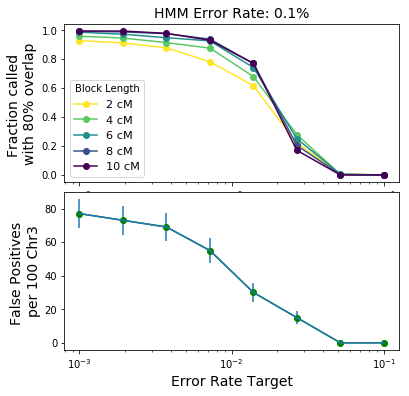

In [55]:
plot_fp_power_errors(error_vec, bl_lens, fps, power, title="HMM Error Rate: 0.1%", savepath="./figures_test/hmm_error_rate001_powerfp.pdf")

# Plot FP rate along genome

In [15]:
### Load all FP Blocks
df_call_fp = collect_fp_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", 
                           ch = 3, nr_iid = 100, blen_cm = 0, output_prefix = "ROHin100/")

### Load the Map Positions
path_map = "../../Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv"
df_map = pd.read_csv(path_map, sep=",", header=None)  # Load the Meta File
map_pos = df_map[0].values

In [16]:
starts = df_call_fp["StartM"].values
ends = df_call_fp["EndM"].values

### Create the Binned Statistic
bins10 = np.arange(min(map_pos), max(map_pos), step=0.005)  # 0.1 cM Bins
counts = np.zeros(len(bins10), dtype="int")

for i in range(len(starts)):
    i1 = np.searchsorted(bins10, starts[i])
    i2 = np.searchsorted(bins10, ends[i])
    counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter

### Plot Counts False Positives and SNP density


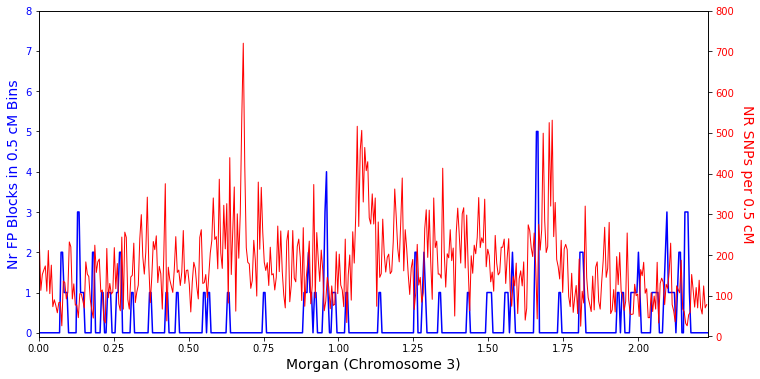

In [17]:
fs = 14

plt.figure(figsize=(12,6))
c1 = "blue"
c2 = "red"

ax = plt.gca()
ax.set_xlim((min(map_pos), max(map_pos)))
ax.plot(bins10, counts, color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax.set_ylim([-0.1, 8])
ax.set_ylabel("Nr FP Blocks in 0.5 cM Bins", fontsize=fs, color=c1)

ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
n, b = np.histogram(map_pos, bins = bins10)
x = (b[1:] + b[:-1]) / 2

ax1.plot(x, n, color=c2, linewidth=1.0)
ax1.tick_params(axis='y', labelcolor=c2)
ax1.set_ylim([-1, 800])
ax1.set_ylabel("NR SNPs per 0.5 cM", color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)


ax.set_xlabel("Morgan (Chromosome 3)", fontsize=fs)
plt.show()

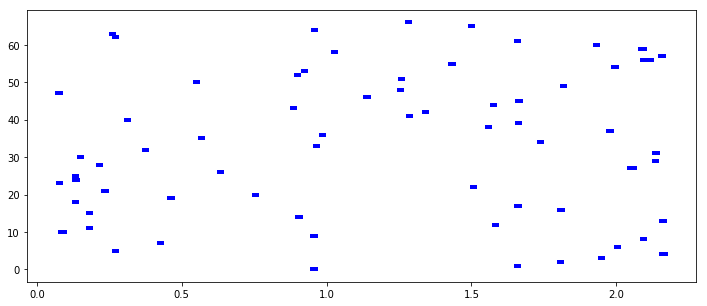

In [18]:
plt.figure(figsize=(12,5))
for i in range(len(df_call_fp)):
    plt.plot([starts[i], ends[i]], [i,i], linewidth=4, color="blue")
plt.show()

# Area 51